# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# Extra requeriment: conda install pillow

data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

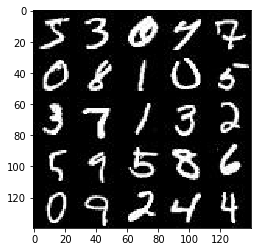

In [5]:
show_n_images = 25
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

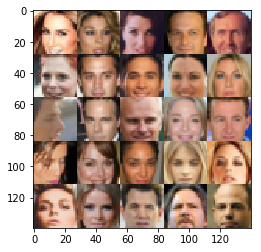

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/marceljaner/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100, figsize=(5,5)):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count = data_shape[0]
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, learning_rate_tf = model_inputs(image_width=image_width,
                                                         image_height=image_height,
                                                         image_channels=image_channels,
                                                         z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real=input_real,
                                input_z=input_z,
                                out_channel_dim=image_channels)
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss,
                             learning_rate=learning_rate_tf, beta1=beta1)
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Scale image from (-0.5, 0.5) to (-1, 1)
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        learning_rate_tf: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        learning_rate_tf: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess=sess,
                                          n_images=show_n_images,
                                          input_z=input_z,
                                          out_channel_dim=image_channels,
                                          image_mode=data_image_mode )
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1024... Generator Loss: 4.5725
Epoch 1/2... Discriminator Loss: 1.1160... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 2.8938
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 2.7261... Generator Loss: 0.0980
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.1302
Epoch 1/2... Discriminator Loss: 1.0871... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 2.0531
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 1.0687
Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 1.4421


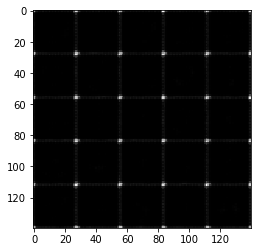

Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 1.4184
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 1.1975
Epoch 1/2... Discriminator Loss: 1.4759... Generator Loss: 0.4424
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 0.5828
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 1.3832


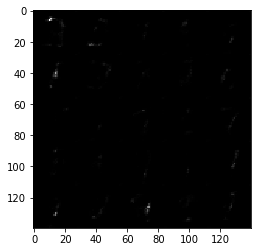

Epoch 1/2... Discriminator Loss: 0.9554... Generator Loss: 1.0198
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 1.2228
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.5508
Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 1.2890
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 1.6211
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 1.3618
Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 1.2586
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 1.9656
Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 1.2063
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 0.7359


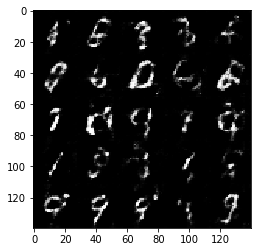

Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.3540
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 1.8651
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 0.5705
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 1.6188
Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 2.0606
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.8493
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.4037


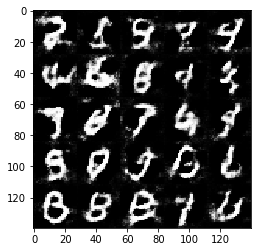

Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 1.5029
Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 1.0022
Epoch 1/2... Discriminator Loss: 1.0307... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.9667
Epoch 1/2... Discriminator Loss: 1.0762... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 1.3925
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 0.7042


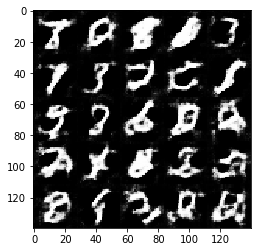

Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 0.7487
Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 0.5257
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 0.8800
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 0.9653
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 1.4037
Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 0.9333
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 1.2399
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 0.7178


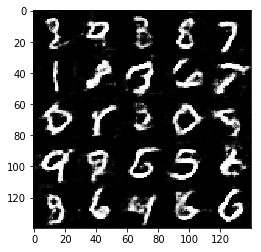

Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.6564
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.4554
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 1.2857
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.1804
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 0.5087


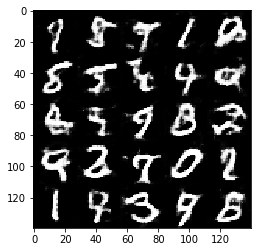

Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 1.2277
Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 1.3205
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 0.8789... Generator Loss: 1.1726
Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.3789
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.9413
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.4016
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 1.4636


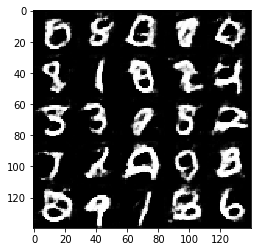

Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 1.7254
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 0.9559
Epoch 2/2... Discriminator Loss: 0.8551... Generator Loss: 0.8907
Epoch 2/2... Discriminator Loss: 2.2863... Generator Loss: 2.0775
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 0.9417
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 0.9773... Generator Loss: 1.5286
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 1.6267
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 0.9959


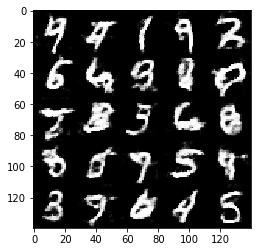

Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 0.5914
Epoch 2/2... Discriminator Loss: 0.8980... Generator Loss: 1.0006
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 0.6301


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 1.6289
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 1.5908
Epoch 1/1... Discriminator Loss: 0.1934... Generator Loss: 2.5669
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 1.6406
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 1.8340
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 1.6121
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 1.6271


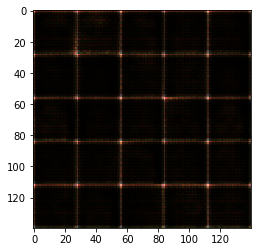

Epoch 1/1... Discriminator Loss: 0.2868... Generator Loss: 2.3643
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 2.0064
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 1.6724
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 1.9755
Epoch 1/1... Discriminator Loss: 0.1353... Generator Loss: 4.7514
Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 7.5560
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 4.6045


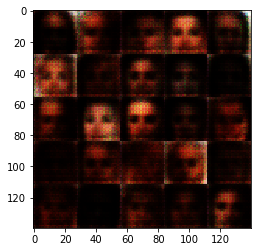

Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 0.3038
Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 5.1999
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 1.7363
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 2.3916
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 1.9242
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.1580
Epoch 1/1... Discriminator Loss: 0.3095... Generator Loss: 3.1695
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.0694


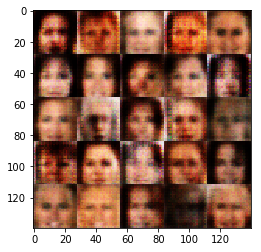

Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 1.7115
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 2.8671
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 2.0004... Generator Loss: 0.2196
Epoch 1/1... Discriminator Loss: 0.5289... Generator Loss: 3.7472
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 4.7438
Epoch 1/1... Discriminator Loss: 2.0014... Generator Loss: 0.2060
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 0.5337... Generator Loss: 3.8382
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 1.0634


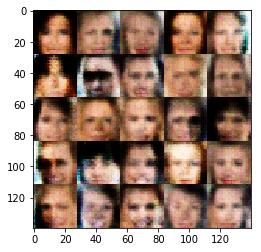

Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 1.7232
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 4.8762
Epoch 1/1... Discriminator Loss: 0.2682... Generator Loss: 2.9617
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 3.6425
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 3.4078
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 1.4780
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 4.9011
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 5.2594
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 2.5047


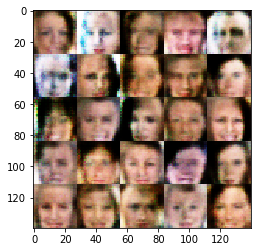

Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 3.1216
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 1.3070
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.2993
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 1.7692
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 3.5675
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 2.8039
Epoch 1/1... Discriminator Loss: 0.3034... Generator Loss: 2.6728
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 1.7245


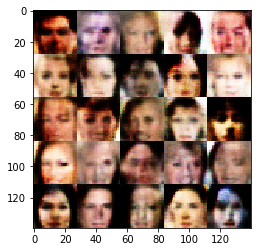

Epoch 1/1... Discriminator Loss: 0.2422... Generator Loss: 2.9409
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 2.9031
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 4.1520
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.6864
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 2.1524
Epoch 1/1... Discriminator Loss: 2.4583... Generator Loss: 2.1472
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 1.8909


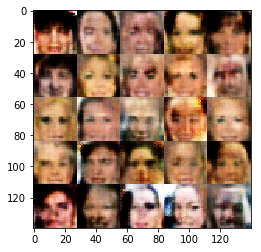

Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 2.1627
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.4990
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 4.5815
Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 2.9293
Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 4.0747
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 5.5617
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 0.3597... Generator Loss: 2.0811
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 1.2580


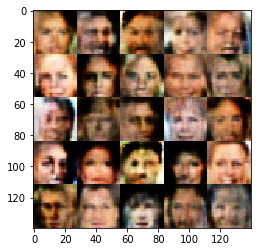

Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.1109
Epoch 1/1... Discriminator Loss: 0.2115... Generator Loss: 4.6083
Epoch 1/1... Discriminator Loss: 0.1965... Generator Loss: 2.8590
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 2.7903
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 0.2415... Generator Loss: 3.3258
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 0.2827... Generator Loss: 2.4548
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.4540


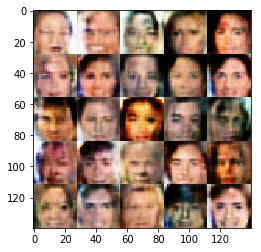

Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 2.6799
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 2.6217
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 1.8728
Epoch 1/1... Discriminator Loss: 0.4676... Generator Loss: 3.1656
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 0.3625... Generator Loss: 1.9880
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 3.1365


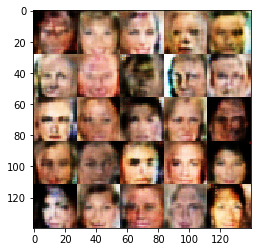

Epoch 1/1... Discriminator Loss: 0.2824... Generator Loss: 2.4867
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 2.8368
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 1.7712
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 4.3058
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 1.4327
Epoch 1/1... Discriminator Loss: 0.2530... Generator Loss: 2.8975
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 1.5769


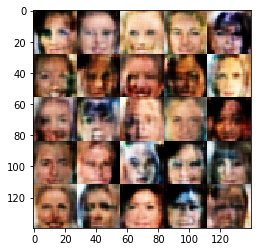

Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 3.1043
Epoch 1/1... Discriminator Loss: 0.3188... Generator Loss: 2.3503
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 3.2813
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 3.4476
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 3.0078
Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 1.8098
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 0.2503... Generator Loss: 2.6944


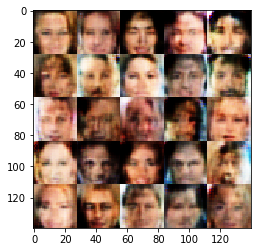

Epoch 1/1... Discriminator Loss: 0.2741... Generator Loss: 3.5067
Epoch 1/1... Discriminator Loss: 4.5201... Generator Loss: 0.0179
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 2.5158
Epoch 1/1... Discriminator Loss: 0.3019... Generator Loss: 2.3051
Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 1.9357
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 4.5700


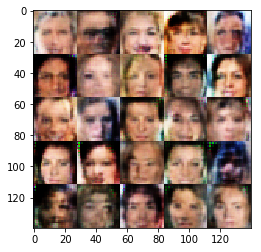

Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 2.3311
Epoch 1/1... Discriminator Loss: 0.2406... Generator Loss: 2.5890
Epoch 1/1... Discriminator Loss: 2.0307... Generator Loss: 2.2966
Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 1.8108
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 1.6806
Epoch 1/1... Discriminator Loss: 0.2578... Generator Loss: 2.3548
Epoch 1/1... Discriminator Loss: 0.3247... Generator Loss: 2.0211
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 0.6937


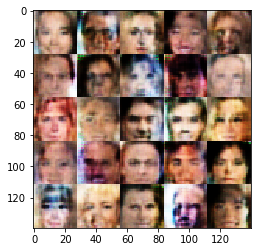

Epoch 1/1... Discriminator Loss: 0.1561... Generator Loss: 4.2514
Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 2.2083
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 2.3096
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 0.6295... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 0.3086... Generator Loss: 1.9324
Epoch 1/1... Discriminator Loss: 0.1774... Generator Loss: 3.2419
Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 1.9224
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.7870


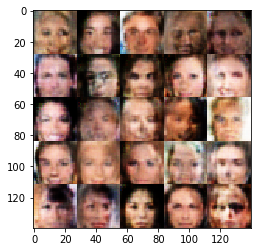

Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 2.6795
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 2.2892
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 1.2818
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 1.4254
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 1.9656
Epoch 1/1... Discriminator Loss: 0.1687... Generator Loss: 3.7714
Epoch 1/1... Discriminator Loss: 0.2557... Generator Loss: 2.5332
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 2.4786


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.